In [1]:
import matplotlib.pyplot as plt
plt.style.use(['science','ieee'])
import numpy as np
import bezpy
import pandas as pd

# setup sample B Field data
Am = np.array([200, 90, 30, 17, 8, 3.5, 1])
Phim = np.array([10, 20, 30, 40, 50, 60, 70])
fm = np.array([0.00009259, 0.00020833, 0.00047619, 0.00111111, 0.00238095, 0.00555555, 0.025])
t = np.linspace(0,60*60*24,60*60*24)

B = np.zeros((7, len(t)))
for m in range(7):
    B[m,:] = Am[m]*np.sin((2*np.pi*fm[m]*t + np.deg2rad(Phim[m])))
Bt = np.sum(B, axis=0)


def draw_table(q, f):
    Kfm = qb.calcZ(f)[1]
    o = pd.DataFrame()
    o["fm (Hz)"], o["Amplitude |Km| (mV/km/nT)"], o["Phase, tm, (deg)"] = fm, np.absolute(Kfm), np.rad2deg(np.angle(Kfm))
    o.index.name = "m"
    return o

    fm (Hz)  Amplitude |Km| (mV/km/nT)  Phase, tm, (deg)
m                                                       
0  0.000093                   0.218831         77.148399
1  0.000208                   0.448030         73.761223
2  0.000476                   0.868053         67.169259
3  0.001111                   1.539196         62.080708
4  0.002381                   2.593522         60.575720
5  0.005556                   4.662465         54.969926
6  0.025000                   9.604690         44.381495
    fm (Hz)  Amplitude |Km| (mV/km/nT)  Phase, tm, (deg)
m                                                       
0  0.000093                   0.218831         77.148399
1  0.000208                   0.448030         73.761223
2  0.000476                   0.868053         67.169259
3  0.001111                   1.539196         62.080708
4  0.002381                   2.593522         60.575720
5  0.005556                   4.662465         54.969926
6  0.025000                   9

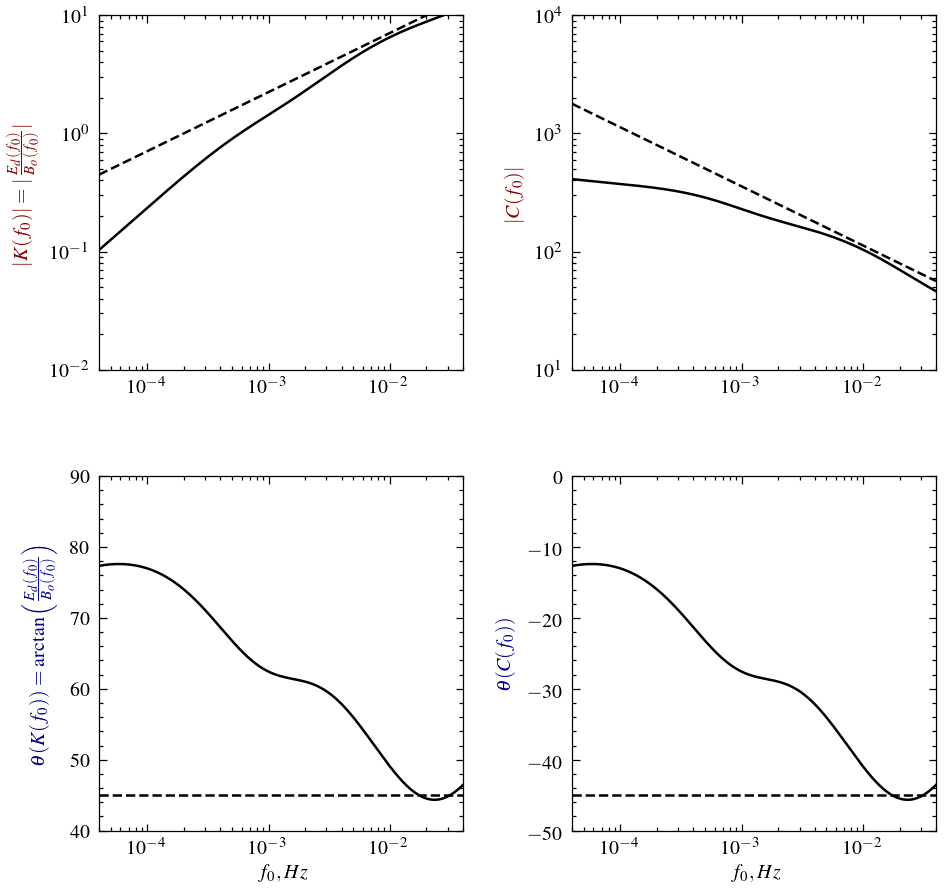

In [2]:
flim = [4e-5,4e-2]
freqs = 10**np.linspace(np.log10(flim[0]), np.log10(flim[1]), 1001)
# Layered Quebec model
qb = bezpy.mt.read_1d_usgs_profile("data/ocean_model_DB1.txt")
Kf = qb.calcZ(freqs)[1]
Cf = Kf/(1j*2*np.pi*freqs)
o = draw_table(qb, fm)
# Convert uniform Earth model
qbu = bezpy.mt.read_1d_usgs_profile("data/ocean_model_DB1.txt")
qbu.resistivities[:] = 1000.
Kfu = qbu.calcZ(freqs)[1]
Cfu = Kfu/(1j*2*np.pi*freqs)
ou = draw_table(qb, fm)
print(o)
print(ou)

fig = plt.figure(dpi=180, figsize=(6, 6))
ax = fig.add_subplot(221)
ax.loglog(freqs, np.absolute(Kf), "k-")
ax.loglog(freqs, np.absolute(Kfu), "k--")
ax.set_xlim(flim)
ax.set_ylim(1e-2,1e1)
ax.set_ylabel(r"$|K(f_0)|=|\frac{E_d(f_0)}{B_o(f_0)}|$", color="darkred")
ax = fig.add_subplot(222)
ax.loglog(freqs, np.absolute(Cf), "k-")
ax.loglog(freqs, np.absolute(Cfu), "k--")
ax.set_xlim(flim)
ax.set_ylim(1e1,1e4)
ax.set_ylabel(r"$|C(f_0)|$", color="darkred")
ax = fig.add_subplot(223)
ax.set_xlabel(r"$f_0, Hz$")
ax.semilogx(freqs, np.rad2deg(np.angle(Kf)), "k-")
ax.semilogx(freqs, np.rad2deg(np.angle(Kfu)), "k--")
ax.set_ylim(40,90)
ax.set_xlim(flim)
ax.set_ylabel(r"$\theta(K(f_0))=\arctan{\left(\frac{E_d(f_0)}{B_o(f_0)}\right)}$", color="darkblue")
ax = fig.add_subplot(224)
ax.set_xlabel(r"$f_0, Hz$")
ax.semilogx(freqs, np.rad2deg(np.angle(Cf)), "k-")
ax.semilogx(freqs, np.rad2deg(np.angle(Cfu)), "k--")
ax.set_ylim(-50, 0)
ax.set_xlim(flim)
ax.set_ylabel(r"$\theta(C(f_0))$", color="darkblue")

fig.subplots_adjust(wspace=0.3, hspace=0.3)

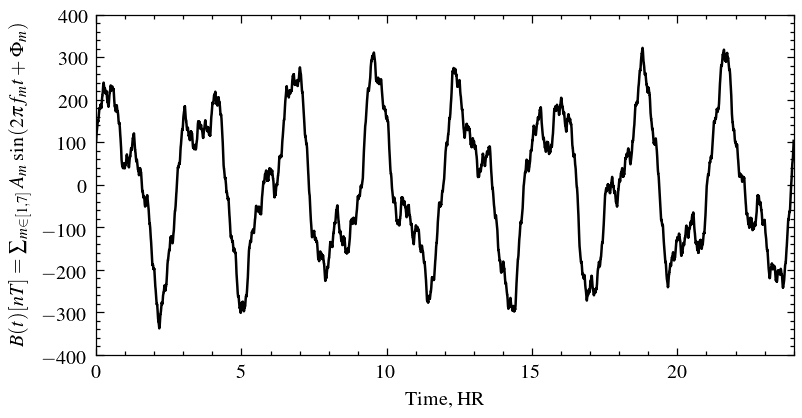

In [3]:
t0 = t/3600.
fig = plt.figure(dpi=180, figsize=(5, 2.5))
ax = fig.add_subplot(111)
ax.plot(t0, Bt, "k")
ax.set_ylabel(r"$B(t)[nT]=\sum_{m\in[1,7]}A_m\sin{(2\pi f_mt+\Phi_m)}$")
ax.set_xlim(0, t0[-1])
ax.set_xlabel("Time, HR")
_ = ax.set_ylim(-400,400)

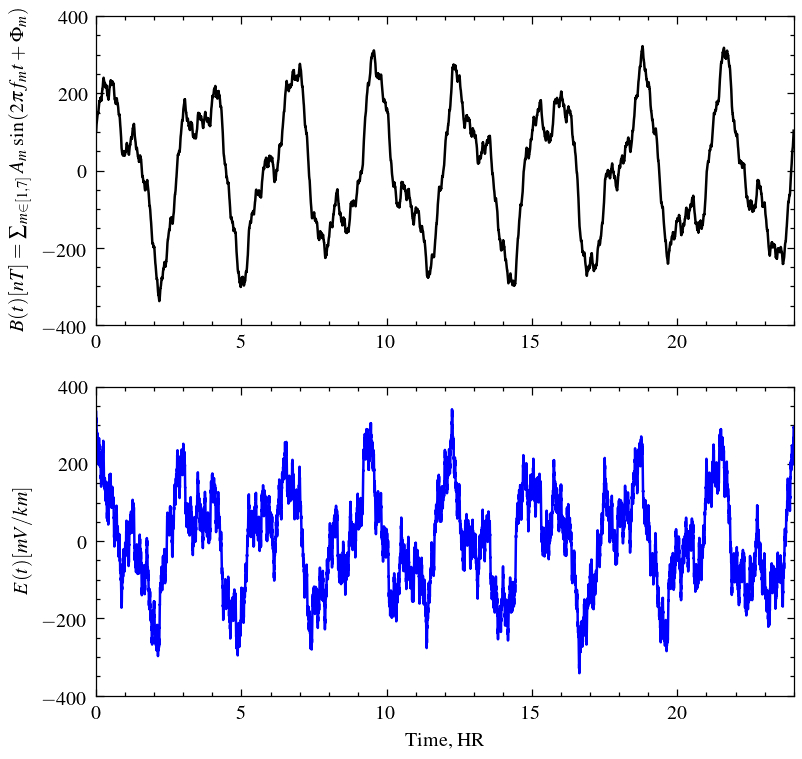

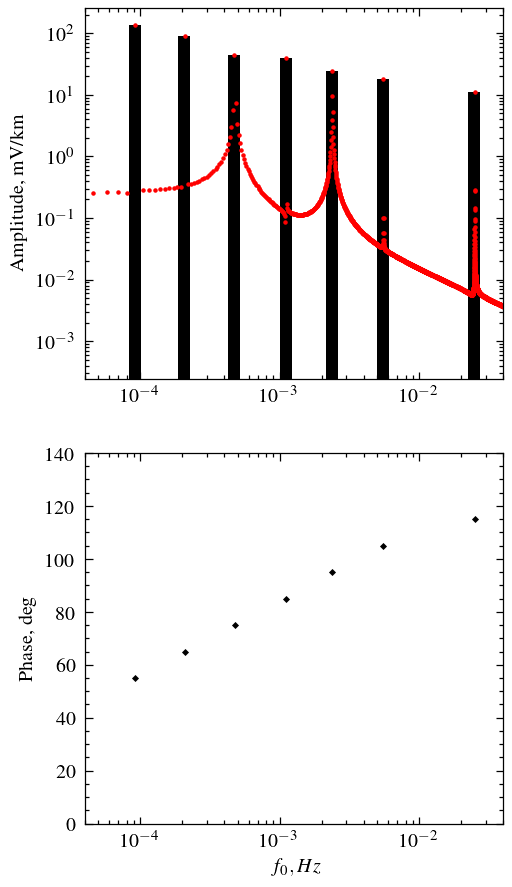

In [4]:
from scipy.fft import fft, fftfreq
def getfft(y, fm, T=1):
    N = len(y)
    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]
    yf = 2.0/N * np.abs(yf[0:N//2])
    Yf = []
    for f in fm:
        i = np.argmin(np.abs(xf-f))
        Yf.append(yf[i])
    return xf, yf, Yf

Kfm = qbu.calcZ(fm)[1]

angles = np.zeros((7))
E = np.zeros((7, len(t)))
for m in range(7):
    E[m,:] = np.absolute(Kfm[m]) * Am[m]*np.sin((2*np.pi*fm[m]*t + np.angle(Kfm[m]) + np.deg2rad(Phim[m])))
    angles[m] = np.rad2deg(np.angle(Kfm[m])) + Phim[m]
Et = np.sum(E, axis=0)

fig = plt.figure(dpi=180, figsize=(5, 5))
ax = fig.add_subplot(211)
ax.plot(t0, Bt, "k")
ax.set_ylabel(r"$B(t)[nT]=\sum_{m\in[1,7]}A_m\sin{(2\pi f_mt+\Phi_m)}$")
ax.set_ylim(-400,400)
ax.set_xlim(0, t0[-1])
ax = fig.add_subplot(212)
ax.plot(t0, Et, "b")
ax.set_xlabel("Time, HR")
ax.set_ylabel(r"$E(t)[mV/km]$")
ax.set_xlim(0, t0[-1])
_ = ax.set_ylim(-400,400)


xf, yf, Yf = getfft(Et, fm)
fig = plt.figure(dpi=180, figsize=(3, 6))
ax = fig.add_subplot(211)
ax.bar(fm, Yf, width=fm*.2)
ax.loglog(xf, yf, "ro", ms=0.8)
ax.set_ylabel("Amplitude, mV/km")
ax.set_xlim(flim)
ax = fig.add_subplot(212)
ax.semilogx(fm, angles, "kD", ms=1, ls="None")
#ax.semilogx(xf, np.rad2deg(af), "ro", ms=0.8)
ax.set_ylim(0,140)
ax.set_xlim(flim)
ax.set_ylabel("Phase, deg")
_ = ax.set_xlabel(r"$f_0, Hz$")

# o = pd.DataFrame()
# o["fm"], o["Amplitude, Em, (mV/km)"], o["Phase, phi_m, (deg)"] = fm, Yf, angles
# o.index.name = "m"
# print(o)

/home/shibaji/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


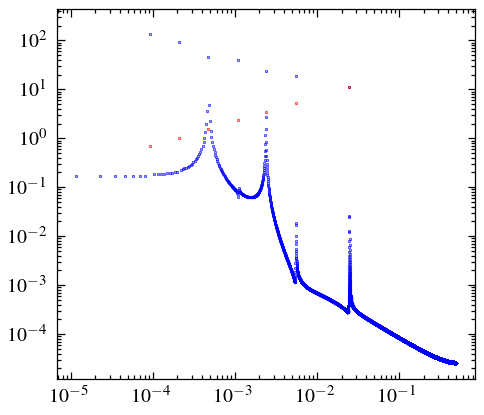

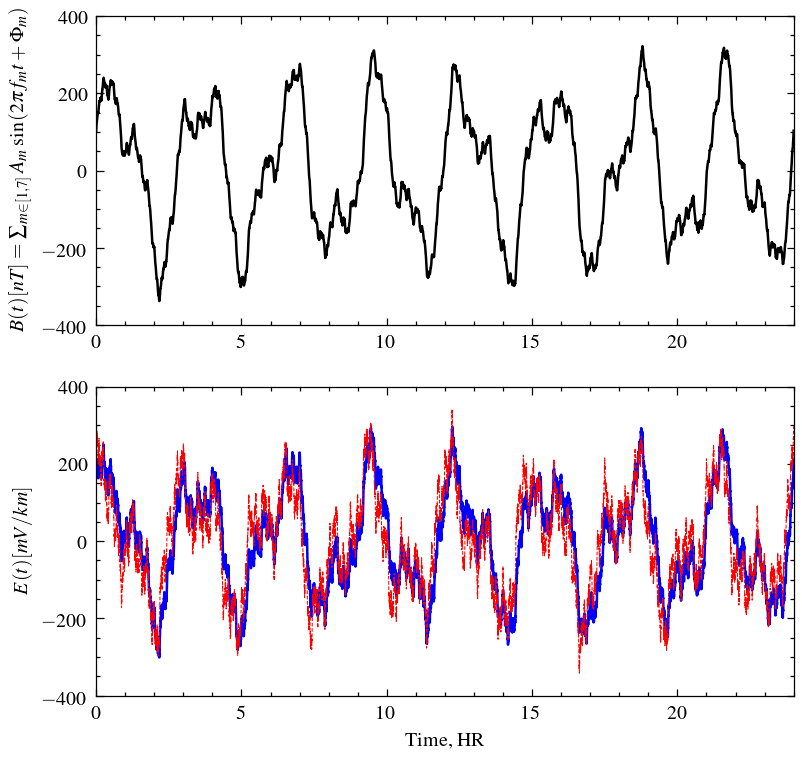

In [5]:
from scipy.fft import fft, fftfreq, ifft
def convolve(a_time, b_freq):
    af = fft(a_time)
    frq = fftfreq(len(a_time), 1)
    for bf, f in zip(b_freq, fm):
        i = np.argmin(abs(f-frq))
        af[i] = af[i]*bf
    ay = ifft(af)
    return af, frq, ay
Bf, fx, Etc = convolve(Bt, Kfm)
fig = plt.figure(dpi=180, figsize=(3, 6))
ax = fig.add_subplot(211)
ax.loglog(fx, 2.0/len(Bt) * np.abs(Bf), "b.", ms=0.5)
ax.loglog(fm, np.abs(Kfm), "r.", ms=0.5)

fig = plt.figure(dpi=180, figsize=(5, 5))
ax = fig.add_subplot(211)
ax.plot(t0, Bt, "k")
ax.set_ylabel(r"$B(t)[nT]=\sum_{m\in[1,7]}A_m\sin{(2\pi f_mt+\Phi_m)}$")
ax.set_ylim(-400,400)
ax.set_xlim(0, t0[-1])
ax = fig.add_subplot(212)
ax.plot(t0, Etc, "b")
ax.plot(t0, Et, "r--", lw=0.4)
ax.set_xlabel("Time, HR")
ax.set_ylabel(r"$E(t)[mV/km]$")
ax.set_xlim(0, t0[-1])
_ = ax.set_ylim(-400,400)

         fm  Amplitude, Em, (mV/km)  Phase, phi_m, (deg)
m                                                       
0  0.000093               43.875482            87.148399
1  0.000208               40.466190            93.761223
2  0.000476               25.155512            97.169259
3  0.001111               26.073751           102.080708
4  0.002381               18.110600           110.575720
5  0.005556               16.316816           114.969926
6  0.025000                9.593365           114.381495


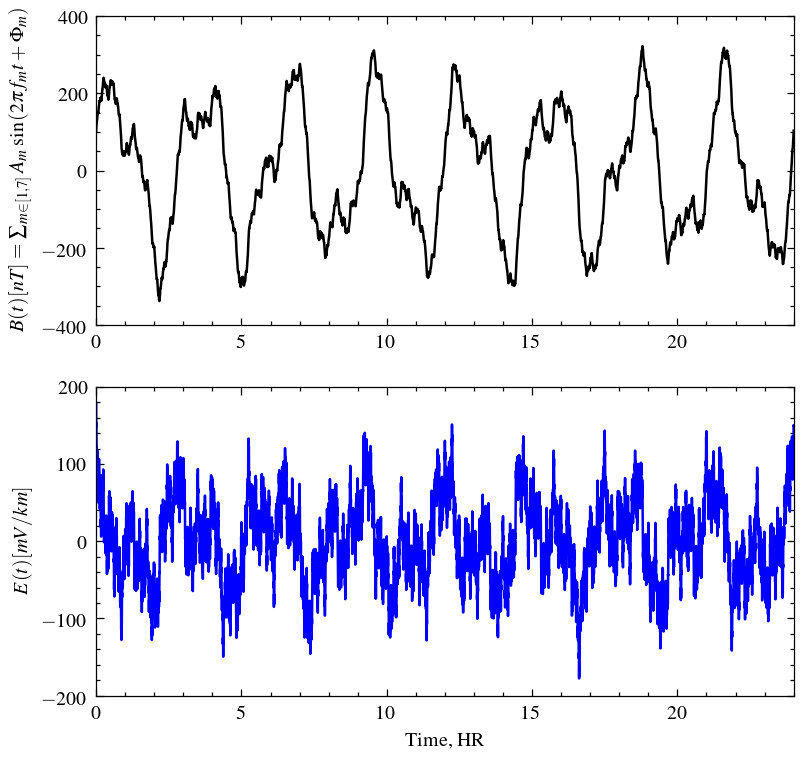

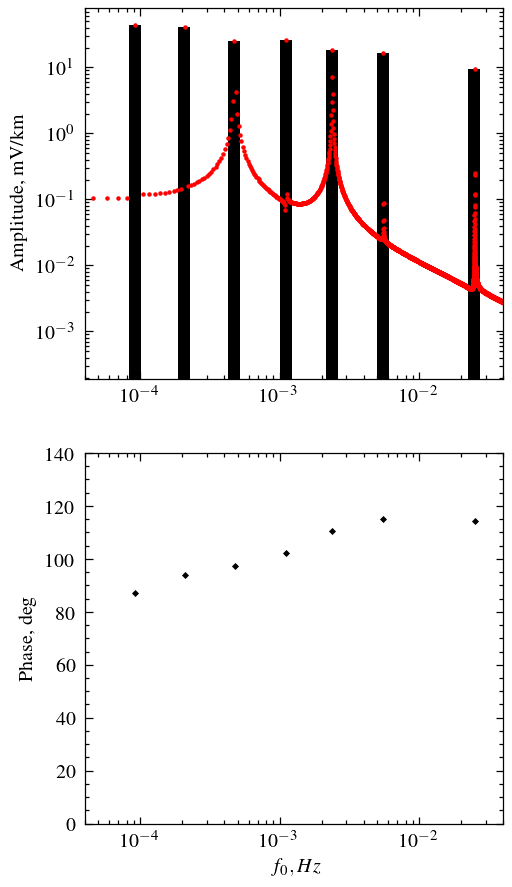

In [6]:
Kfm = qb.calcZ(fm)[1]

E = np.zeros((7, len(t)))
for m in range(7):
    E[m,:] = np.absolute(Kfm[m]) * Am[m]*np.sin((2*np.pi*fm[m]*t + np.angle(Kfm[m]) + np.deg2rad(Phim[m])))
    angles[m] = np.rad2deg(np.angle(Kfm[m])) + Phim[m]
Et = np.sum(E, axis=0)

fig = plt.figure(dpi=180, figsize=(5, 5))
ax = fig.add_subplot(211)
ax.plot(t0, Bt, "k")
ax.set_ylabel(r"$B(t)[nT]=\sum_{m\in[1,7]}A_m\sin{(2\pi f_mt+\Phi_m)}$")
ax.set_ylim(-400,400)
ax.set_xlim(0, t0[-1])
ax = fig.add_subplot(212)
ax.plot(t0, Et, "b")
ax.set_xlabel("Time, HR")
ax.set_ylabel(r"$E(t)[mV/km]$")
ax.set_xlim(0, t0[-1])
_ = ax.set_ylim(-200,200)

xf, yf, Yf = getfft(Et, fm)
fig = plt.figure(dpi=180, figsize=(3, 6))
ax = fig.add_subplot(211)
ax.bar(fm, Yf, width=fm*.2)
ax.loglog(xf, yf, "ro", ms=0.8)
ax.set_ylabel("Amplitude, mV/km")
ax.set_xlim(flim)
ax = fig.add_subplot(212)
ax.semilogx(fm, angles, "kD", ms=1, ls="None")
#ax.semilogx(xf, np.rad2deg(af), "ro", ms=0.8)
ax.set_ylim(0,140)
ax.set_xlim(flim)
ax.set_ylabel("Phase, deg")
_ = ax.set_xlabel(r"$f_0, Hz$")

o = pd.DataFrame()
o["fm"], o["Amplitude, Em, (mV/km)"], o["Phase, phi_m, (deg)"] = fm, Yf, angles
o.index.name = "m"
print(o)